# 📰 Detectarea Știrilor False folosind NLP

---

## 📌 Definirea problemei

Scopul acestui proiect este dezvoltarea unui sistem de **Procesare a Limbajului Natural (NLP)** capabil să clasifice automat articolele de presă ca fiind **știri reale** sau **știri false**, pe baza conținutului lor textual.

În contextul actual, volumul mare de informații publicate online face dificilă verificarea manuală a veridicității știrilor. Din acest motiv, soluțiile automate pot contribui la identificarea rapidă a conținutului potențial înșelător.

---

## 🎯 Task-ul NLP

Problema abordată în acest proiect este una de **clasificare de text**, în care fiecare articol de presă este încadrat într-una dintre următoarele două clase:

- **FAKE** – știre falsă  
- **REAL** – știre reală  

📥 **Input:** textul articolului (titlu + conținut)  
📤 **Output:** eticheta corespunzătoare (`FAKE` / `REAL`)

---

## 💡 Motivație

### 🔹 Motivație practică
Detectarea automată a știrilor false este importantă pentru:

- reducerea răspândirii dezinformării;
- sprijinirea platformelor media și a rețelelor sociale;
- asistarea utilizatorilor în evaluarea credibilității informațiilor.

### 🔹 Motivație teoretică
Din punct de vedere teoretic, acest task permite analizarea și compararea performanței dintre:

- modele clasice de învățare automată bazate pe reprezentări statistice ale textului;
- modele neurale capabile să surprindă relații mai complexe din limbaj.

---

## 🧠 Ipoteză

Ipoteza de la care pornește acest proiect este că **știrile false prezintă tipare lingvistice și structurale diferite față de știrile reale**, iar aceste diferențe pot fi învățate de modele NLP pentru a realiza o clasificare corectă.

---

## 📝 Observație

> Acest proiect va implementa și compara două abordări diferite:
> - un model clasic de învățare automată;
> - un model bazat pe rețele neuronale.

---




## 📊 Descrierea corpusului

Pentru acest proiect a fost utilizat datasetul **Fake and Real News Dataset**, disponibil public pe platforma Kaggle. Datasetul conține articole de presă etichetate ca fiind știri reale sau știri false.

### Structura datasetului
Datasetul este alcătuit din două fișiere CSV:
- `Fake.csv`, care conține știri false;
- `True.csv`, care conține știri reale.

Fiecare articol de presă este descris prin următoarele câmpuri:
- **title** – titlul articolului;
- **text** – conținutul articolului;
- **subject** – categoria știrii;
- **date** – data publicării.

Pentru a facilita procesul de clasificare, cele două fișiere vor fi combinate într-un singur dataset, iar fiecărui articol îi va fi asociată o etichetă:
- `FAKE` pentru știrile false;
- `REAL` pentru știrile reale.

### Dimensiunea corpusului
Datasetul conține peste **40.000 de articole**, depășind cerința minimă de 10.000 de exemple impusă de temă. Distribuția relativ echilibrată între cele două clase permite antrenarea și evaluarea corectă a modelelor de clasificare.

### Împărțirea datelor
Datele vor fi împărțite în trei subseturi:
- **Training set** – utilizat pentru antrenarea modelelor;
- **Validation set** – utilizat pentru reglarea hiperparametrilor;
- **Test set** – utilizat pentru evaluarea finală a performanței.

Această separare asigură o evaluare corectă și evită supraînvățarea modelelor.


In [3]:
import pandas as pd

# Incarcam dataseturile
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

# Afisam primele randuri pentru inspectie
fake_df.head(), true_df.head()


(                                               title  \
 0   Donald Trump Sends Out Embarrassing New Year’...   
 1   Drunk Bragging Trump Staffer Started Russian ...   
 2   Sheriff David Clarke Becomes An Internet Joke...   
 3   Trump Is So Obsessed He Even Has Obama’s Name...   
 4   Pope Francis Just Called Out Donald Trump Dur...   
 
                                                 text subject  \
 0  Donald Trump just couldn t wish all Americans ...    News   
 1  House Intelligence Committee Chairman Devin Nu...    News   
 2  On Friday, it was revealed that former Milwauk...    News   
 3  On Christmas day, Donald Trump announced that ...    News   
 4  Pope Francis used his annual Christmas Day mes...    News   
 
                 date  
 0  December 31, 2017  
 1  December 31, 2017  
 2  December 30, 2017  
 3  December 29, 2017  
 4  December 25, 2017  ,
                                                title  \
 0  As U.S. budget fight looms, Republicans flip t...   
 1  U

In [4]:
# Adaugam coloana label
fake_df["label"] = "FAKE"
true_df["label"] = "REAL"


In [5]:
# Combinam cele doua dataseturi intr-unul singur
df = pd.concat([fake_df, true_df], ignore_index=True)

# Amestecam randurile
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [6]:
# Dimensiunea datasetului final
df.shape


(44898, 5)

In [7]:
# Distributia claselor
df["label"].value_counts()


label
FAKE    23481
REAL    21417
Name: count, dtype: int64

Analiză exploratorie (EDA) & decizii de preprocesare

In [8]:
df.isnull().sum()


title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [9]:
# Lungimea textului (numar de caractere)
df["text_length"] = df["text"].str.len()

df[["text_length", "label"]].groupby("label").describe()


text_length                                                         \
            count         mean          std  min     25%     50%     75%   
label                                                                      
FAKE      23481.0  2547.396235  2532.884399  1.0  1433.0  2166.0  3032.0   
REAL      21417.0  2383.278517  1684.835730  1.0   914.0  2222.0  3237.0   

                
           max  
label           
FAKE   51794.0  
REAL   29781.0

## 🔍 Analiză exploratorie și decizii de preprocesare

Înainte de aplicarea tehnicilor de preprocesare, a fost realizată o analiză exploratorie a datasetului pentru a înțelege structura și caracteristicile textelor.

Analiza a evidențiat faptul că articolele de presă au lungimi variabile, iar distribuția lungimii textelor diferă ușor între știrile reale și cele false. Acest aspect sugerează că informația semantică este răspândită pe întregul conținut al articolelor, nu doar în titlu.

### Selecția coloanelor
Pentru acest proiect, s-a decis utilizarea următoarelor câmpuri:
- **title** – titlul articolului;
- **text** – conținutul complet al articolului.

Câmpurile **subject** și **date** nu au fost utilizate, deoarece scopul proiectului este analiza conținutului lingvistic, fără a introduce informații auxiliare care ar putea influența artificial clasificarea.

Această decizie permite evaluarea corectă a capacității modelelor NLP de a învăța tipare strict din text.


# 🧹 Preprocesarea textului

În acest capitol sunt aplicate tehnici de preprocesare asupra textelor din dataset, cu scopul de a le transforma într-o formă adecvată pentru modelele NLP.

Preprocesarea este un pas esențial, deoarece reduce zgomotul din date, normalizează informația textuală și îmbunătățește performanța modelelor de clasificare.

---

## 📌 Pașii de preprocesare

Preprocesarea va fi realizată incremental, prin următorii pași:

1. **Curățarea textului** (eliminarea caracterelor inutile și a spațiilor în exces)
2. **Lowercasing** (transformarea tuturor caracterelor în litere mici)
3. **Tokenizare**
4. **Eliminarea stopwords**
5. **Lematizare**
6. **Combinarea titlului cu textul articolului**
7. **Crearea textului final utilizat de modele**

Fiecare pas va fi explicat și implementat separat, pentru a evidenția rolul său în pipeline-ul NLP.

---



In [10]:
import re

def clean_text(text):
    # Eliminam newline-uri
    text = text.replace("\n", " ")
    
    # Eliminam link-uri
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # Eliminam caractere non-ASCII
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    
    # Eliminam spatii multiple
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()


In [11]:
# Aplicam curatarea pe coloanele textuale
df["clean_title"] = df["title"].apply(clean_text)
df["clean_text"] = df["text"].apply(clean_text)

df[["title", "clean_title"]].head()


,title,clean_title
0,Ben Stein Calls Out 9th Circuit Court: Committ...,Ben Stein Calls Out 9th Circuit Court: Committ...
1,Trump drops Steve Bannon from National Securit...,Trump drops Steve Bannon from National Securit...
2,Puerto Rico expects U.S. to lift Jones Act shi...,Puerto Rico expects U.S. to lift Jones Act shi...
3,OOPS: Trump Just Accidentally Confirmed He Le...,OOPS: Trump Just Accidentally Confirmed He Lea...
4,Donald Trump heads for Scotland to reopen a go...,Donald Trump heads for Scotland to reopen a go...


In [13]:
def lowercase_text(text):
    return text.lower()


In [14]:
df["lower_title"] = df["clean_title"].apply(lowercase_text)
df["lower_text"] = df["clean_text"].apply(lowercase_text)

df[["clean_title", "lower_title"]].head()


,clean_title,lower_title
0,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein calls out 9th circuit court: committ...
1,Trump drops Steve Bannon from National Securit...,trump drops steve bannon from national securit...
2,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u.s. to lift jones act shi...
3,OOPS: Trump Just Accidentally Confirmed He Lea...,oops: trump just accidentally confirmed he lea...
4,Donald Trump heads for Scotland to reopen a go...,donald trump heads for scotland to reopen a go...


In [15]:
def tokenize_text(text):
    return text.split()


In [16]:
df["tokens_title"] = df["lower_title"].apply(tokenize_text)
df["tokens_text"] = df["lower_text"].apply(tokenize_text)

df[["lower_text", "tokens_text"]].head()


,lower_text,tokens_text
0,"21st century wire says ben stein, reputable pr...","[21st, century, wire, says, ben, stein,, reput..."
1,washington (reuters) - u.s. president donald t...,"[washington, (reuters), -, u.s., president, do..."
2,(reuters) - puerto rico governor ricardo rosse...,"[(reuters), -, puerto, rico, governor, ricardo..."
3,"on monday, donald trump once again embarrassed...","[on, monday,, donald, trump, once, again, emba..."
4,"glasgow, scotland (reuters) - most u.s. presid...","[glasgow,, scotland, (reuters), -, most, u.s.,..."


In [17]:
import string

def remove_punctuation(tokens):
    cleaned_tokens = []
    for token in tokens:
        # Eliminam punctuatia de la inceput si sfarsit
        token = token.strip(string.punctuation)
        if token:  # pastram doar tokenii ne-goi
            cleaned_tokens.append(token)
    return cleaned_tokens


In [21]:
df["tokens_title"] = df["tokens_title"].apply(remove_punctuation)
df["tokens_text"] = df["tokens_text"].apply(remove_punctuation)

df["tokens_text"].head()


0    [21st, century, wire, says, ben, stein, reputa...
1    [washington, reuters, u.s, president, donald, ...
2    [reuters, puerto, rico, governor, ricardo, ros...
3    [on, monday, donald, trump, once, again, embar...
4    [glasgow, scotland, reuters, most, u.s, presid...
Name: tokens_text, dtype: object

In [23]:
import nltk
from nltk.corpus import stopwords

# Descarcam stopwords (o singura data)
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

list(stop_words)[:10]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rares\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['yourselves',
 'myself',
 'doesn',
 'were',
 'before',
 'such',
 "shouldn't",
 'theirs',
 'd',
 "we're"]

In [24]:
def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words]


In [ ]:
def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words]


In [25]:
df["tokens_title"] = df["tokens_title"].apply(remove_stopwords)
df["tokens_text"] = df["tokens_text"].apply(remove_stopwords)

df["tokens_text"].head()


0    [21st, century, wire, says, ben, stein, reputa...
1    [washington, reuters, u.s, president, donald, ...
2    [reuters, puerto, rico, governor, ricardo, ros...
3    [monday, donald, trump, embarrassed, country, ...
4    [glasgow, scotland, reuters, u.s, presidential...
Name: tokens_text, dtype: object

### Eliminarea stopwords


A fost utilizată lista standard de stopwords din biblioteca NLTK, o abordare comună și bine acceptată în aplicațiile NLP clasice.


### Lematizare


Aducerea cuvintelor la forma lor de bază (lemma).


In [33]:
from nltk.stem import WordNetLemmatizer

# Descarcam resursele necesare
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rares\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rares\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]


In [35]:
df["tokens_title"] = df["tokens_title"].apply(lemmatize_tokens)
df["tokens_text"] = df["tokens_text"].apply(lemmatize_tokens)

df["tokens_text"].head()


0    [21st, century, wire, say, ben, stein, reputab...
1    [washington, reuters, u.s, president, donald, ...
2    [reuters, puerto, rico, governor, ricardo, ros...
3    [monday, donald, trump, embarrassed, country, ...
4    [glasgow, scotland, reuters, u.s, presidential...
Name: tokens_text, dtype: object

In [36]:
### Combinarea titlului cu textul & crearea textului final


In [37]:
def combine_tokens(title_tokens, text_tokens):
    return title_tokens + text_tokens


In [38]:
df["final_tokens"] = df.apply(
    lambda row: combine_tokens(row["tokens_title"], row["tokens_text"]),
    axis=1
)

df["final_tokens"].head()

0    [ben, stein, call, 9th, circuit, court, commit...
1    [trump, drop, steve, bannon, national, securit...
2    [puerto, rico, expects, u.s, lift, jones, act,...
3    [oops, trump, accidentally, confirmed, leaked,...
4    [donald, trump, head, scotland, reopen, golf, ...
Name: final_tokens, dtype: object

In [39]:
df["final_text"] = df["final_tokens"].apply(lambda tokens: " ".join(tokens))

df[["final_text", "label"]].head()


,final_text,label
0,ben stein call 9th circuit court committed cou...,FAKE
1,trump drop steve bannon national security coun...,REAL
2,puerto rico expects u.s lift jones act shippin...,REAL
3,oops trump accidentally confirmed leaked israe...,FAKE
4,donald trump head scotland reopen golf resort ...,REAL


### Combinarea titlului cu textul și crearea textului final

În acest pas, tokenii obținuți din titlul și conținutul fiecărui articol au fost combinați într-o singură secvență. Această abordare permite utilizarea simultană a informației sintetice din titlu și a contextului oferit de textul complet al știrii.

După combinarea tokenilor, aceștia au fost reconstruiți într-un text final, care va fi utilizat ca intrare pentru modelele de clasificare. Astfel, fiecare articol este reprezentat printr-un text curățat, normalizat și coerent din punct de vedere lingvistic.


### Împărțirea datelor (Train / Validation / Test)

- **Training set (70%)** – utilizat pentru antrenarea modelelor;
- **Validation set (15%)** – utilizat pentru reglarea hiperparametrilor și selecția modelelor;
- **Test set (15%)** – utilizat exclusiv pentru evaluarea finală a performanței.

In [42]:
from sklearn.model_selection import train_test_split

X = df["final_text"]
y = df["label"]

# Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)


In [44]:
print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

print("\nDistribuția claselor:")
print("Train:\n", y_train.value_counts(normalize=True))
print("\nValidation:\n", y_val.value_counts(normalize=True))
print("\nTest:\n", y_test.value_counts(normalize=True))


Train size: (31428,)
Validation size: (6735,)
Test size: (6735,)

Distribuția claselor:
Train:
 label
FAKE    0.522973
REAL    0.477027
Name: proportion, dtype: float64

Validation:
 label
FAKE    0.52294
REAL    0.47706
Name: proportion, dtype: float64

Test:
 label
FAKE    0.523088
REAL    0.476912
Name: proportion, dtype: float64


# 🤖 Modelul 1 – Abordare clasică (TF-IDF + Logistic Regression)

În această secțiune este implementat primul model de clasificare pentru detectarea știrilor false, bazat pe o abordare clasică de procesare a limbajului natural.

Modelul utilizează:
- reprezentarea textuală **TF-IDF (Term Frequency – Inverse Document Frequency)**;
- un clasificator **Logistic Regression**, ales pentru stabilitatea și interpretabilitatea sa în sarcini de clasificare a textelor.

---

## 🎯 Obiectivul Modelului 1

Scopul acestui model este de a evalua cât de bine pot fi clasificate știrile reale și false folosind reprezentări statistice ale textului, fără a ține cont de ordinea cuvintelor sau de contextul semantic profund.

Modelul 1 servește drept:
- **baseline solid** pentru problemă;
- punct de comparație pentru modelul neural implementat ulterior.

---

## 🧠 Strategia de antrenare și evaluare

Pentru acest model vor fi testate **trei configurații diferite de TF-IDF**, folosind același clasificator (Logistic Regression):

1. **TF-IDF Baseline (parametri default)**  
   – utilizat ca punct de referință.

2. **TF-IDF Custom – Configurația 1**  
   – vocabular limitat și utilizarea de bigrame, pentru a surprinde expresii relevante din știrile false.

3. **TF-IDF Custom – Configurația 2**  
   – variantă ajustată a configurației anterioare, pentru a analiza impactul modificării parametrilor.

Performanța fiecărei configurații va fi evaluată pe setul de validare folosind metrici standard de clasificare, iar cea mai bună configurație va fi ulterior evaluată pe setul de test.


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF baseline (parametri default)
tfidf_baseline = TfidfVectorizer()

# Fit doar pe setul de antrenare
X_train_tfidf_base = tfidf_baseline.fit_transform(X_train)

# Transform pe validation si test
X_val_tfidf_base = tfidf_baseline.transform(X_val)
X_test_tfidf_base = tfidf_baseline.transform(X_test)


In [46]:
print("Train TF-IDF shape:", X_train_tfidf_base.shape)
print("Validation TF-IDF shape:", X_val_tfidf_base.shape)
print("Test TF-IDF shape:", X_test_tfidf_base.shape)


Train TF-IDF shape: (31428, 97874)
Validation TF-IDF shape: (6735, 97874)
Test TF-IDF shape: (6735, 97874)


In [49]:
from sklearn.linear_model import LogisticRegression

# Clasificatorul (setari simple, stabile)
log_reg = LogisticRegression(max_iter=1000)

# Antrenare pe train
log_reg.fit(X_train_tfidf_base, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [50]:
y_val_pred_base = log_reg.predict(X_val_tfidf_base)

# optional: probabilitati (utile mai tarziu pentru PR-AUC)
y_val_proba_base = log_reg.predict_proba(X_val_tfidf_base)[:, 1]


In [51]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

macro_f1_base = f1_score(y_val, y_val_pred_base, average="macro")
print("Macro-F1 (baseline):", macro_f1_base)

print("\nClassification report (baseline):")
print(classification_report(y_val, y_val_pred_base))


Macro-F1 (baseline): 0.9904793828632779

Classification report (baseline):
              precision    recall  f1-score   support

        FAKE       0.99      0.99      0.99      3522
        REAL       0.99      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



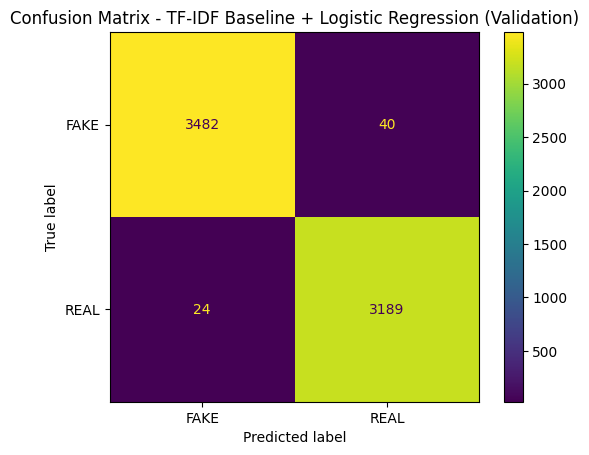

In [52]:
cm = confusion_matrix(y_val, y_val_pred_base, labels=["FAKE", "REAL"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"])
disp.plot()
plt.title("Confusion Matrix - TF-IDF Baseline + Logistic Regression (Validation)")
plt.show()


## 🔧 TF-IDF Custom – Configurația 1

În această etapă este implementată prima variantă personalizată de TF-IDF, cu scopul de a analiza impactul ajustării parametrilor asupra performanței modelului de clasificare.

Spre deosebire de configurația baseline, această variantă utilizează:
- un vocabular limitat;
- n-grame (unigrame și bigrame);
- filtrarea termenilor foarte rari sau foarte frecvenți.

Aceste ajustări au ca scop reducerea zgomotului din date și surprinderea expresiilor relevante pentru detectarea știrilor false.

---

### Parametrii utilizați
- **max_features** = 20.000  
- **ngram_range** = (1, 2)  
- **min_df** = 5  
- **max_df** = 0.9  
- **sublinear_tf** = True

Această configurație reprezintă prima contribuție proprie în cadrul Modelului 1.


tfidf_custom_v1 = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)


In [57]:
tfidf_custom_v1 = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)


In [58]:
# Fit DOAR pe train
X_train_tfidf_c1 = tfidf_custom_v1.fit_transform(X_train)

# Transform pe validation si test
X_val_tfidf_c1 = tfidf_custom_v1.transform(X_val)
X_test_tfidf_c1 = tfidf_custom_v1.transform(X_test)


In [59]:
print("Train TF-IDF (Custom v1) shape:", X_train_tfidf_c1.shape)
print("Validation TF-IDF (Custom v1) shape:", X_val_tfidf_c1.shape)
print("Test TF-IDF (Custom v1) shape:", X_test_tfidf_c1.shape)


Train TF-IDF (Custom v1) shape: (31428, 20000)
Validation TF-IDF (Custom v1) shape: (6735, 20000)
Test TF-IDF (Custom v1) shape: (6735, 20000)


In [62]:
log_reg_c1 = LogisticRegression(max_iter=1000)
log_reg_c1.fit(X_train_tfidf_c1, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [63]:
y_val_pred_c1 = log_reg_c1.predict(X_val_tfidf_c1)


from sklearn.metrics import classification_report, f1_score

macro_f1_c1 = f1_score(y_val, y_val_pred_c1, average="macro")
print("Macro-F1 (Custom v1):", macro_f1_c1)

print("\nClassification report (Custom v1):")
print(classification_report(y_val, y_val_pred_c1))


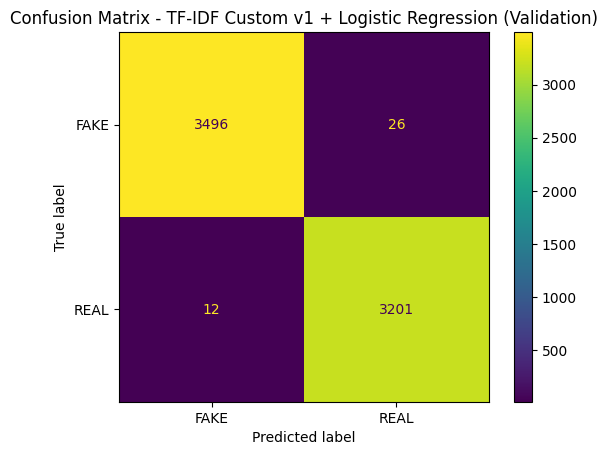

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_c1 = confusion_matrix(y_val, y_val_pred_c1, labels=["FAKE", "REAL"])
disp_c1 = ConfusionMatrixDisplay(confusion_matrix=cm_c1, display_labels=["FAKE", "REAL"])
disp_c1.plot()
plt.title("Confusion Matrix - TF-IDF Custom v1 + Logistic Regression (Validation)")
plt.show()


## 🔧 TF-IDF Custom – Configurația 2

În această etapă este testată a doua configurație personalizată TF-IDF. Scopul este de a analiza impactul dimensiunii vocabularului asupra performanței modelului.

Față de configurația Custom v1, în această variantă se modifică doar:
- **max_features** (vocabular mai mare)

Restul parametrilor rămân identici, pentru a păstra comparația corectă.

---

### Parametrii utilizați
- **max_features** = 30.000  (diferența față de v1)
- **ngram_range** = (1, 2)
- **min_df** = 5
- **max_df** = 0.9
- **sublinear_tf** = True


In [66]:
tfidf_custom_v2 = TfidfVectorizer(
    max_features=30000,   # diferenta fata de v1
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)


In [67]:
# Fit DOAR pe train
X_train_tfidf_c2 = tfidf_custom_v2.fit_transform(X_train)

# Transform pe validation si test
X_val_tfidf_c2 = tfidf_custom_v2.transform(X_val)
X_test_tfidf_c2 = tfidf_custom_v2.transform(X_test)


In [68]:
print("Train TF-IDF (Custom v2) shape:", X_train_tfidf_c2.shape)
print("Validation TF-IDF (Custom v2) shape:", X_val_tfidf_c2.shape)
print("Test TF-IDF (Custom v2) shape:", X_test_tfidf_c2.shape)


Train TF-IDF (Custom v2) shape: (31428, 30000)
Validation TF-IDF (Custom v2) shape: (6735, 30000)
Test TF-IDF (Custom v2) shape: (6735, 30000)


In [69]:
log_reg_c2 = LogisticRegression(max_iter=1000)
log_reg_c2.fit(X_train_tfidf_c2, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [70]:
y_val_pred_c2 = log_reg_c2.predict(X_val_tfidf_c2)


In [71]:
from sklearn.metrics import classification_report, f1_score

macro_f1_c2 = f1_score(y_val, y_val_pred_c2, average="macro")
print("Macro-F1 (Custom v2):", macro_f1_c2)

print("\nClassification report (Custom v2):")
print(classification_report(y_val, y_val_pred_c2))


Macro-F1 (Custom v2): 0.9943469867382911

Classification report (Custom v2):
              precision    recall  f1-score   support

        FAKE       1.00      0.99      0.99      3522
        REAL       0.99      1.00      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



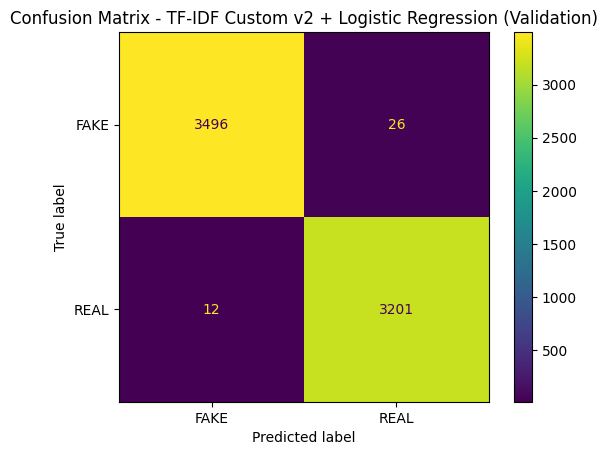

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_c2 = confusion_matrix(y_val, y_val_pred_c2, labels=["FAKE", "REAL"])
disp_c2 = ConfusionMatrixDisplay(confusion_matrix=cm_c2, display_labels=["FAKE", "REAL"])
disp_c2.plot()
plt.title("Confusion Matrix - TF-IDF Custom v2 + Logistic Regression (Validation)")
plt.show()


## ✅ Selecția configurației finale (Modelul 1)

Au fost testate trei configurații pentru Modelul 1 (TF-IDF + Logistic Regression), evaluate pe setul de validare:

- **Baseline (TF-IDF default)** – utilizat ca punct de referință;
- **TF-IDF Custom v1 (20.000 features, unigrame+bigrame)**;
- **TF-IDF Custom v2 (30.000 features, unigrame+bigrame)**.

### Concluzie
Configurația **TF-IDF Custom v1** a obținut cea mai bună performanță pe setul de validare (Macro-F1) și oferă un compromis optim între performanță și complexitate (vocabular mai mic decât baseline/v2).

Prin urmare, această configurație este aleasă ca **Modelul 1 final** și va fi re-antrenată pe datele combinate (**train + validation**), urmând ca evaluarea finală să fie realizată o singură dată pe setul de test.


In [73]:
import pandas as pd

X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

print("Train+Val size:", X_trainval.shape, y_trainval.shape)


Train+Val size: (38163,) (38163,)


In [74]:
tfidf_final_m1 = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)

X_trainval_tfidf = tfidf_final_m1.fit_transform(X_trainval)
X_test_tfidf = tfidf_final_m1.transform(X_test)

print("Train+Val TF-IDF shape:", X_trainval_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)


Train+Val TF-IDF shape: (38163, 20000)
Test TF-IDF shape: (6735, 20000)


Macro-F1 (Model 1 FINAL - TEST): 0.9958342927699156

Classification report (Model 1 FINAL - TEST):
              precision    recall  f1-score   support

        FAKE       1.00      0.99      1.00      3523
        REAL       0.99      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



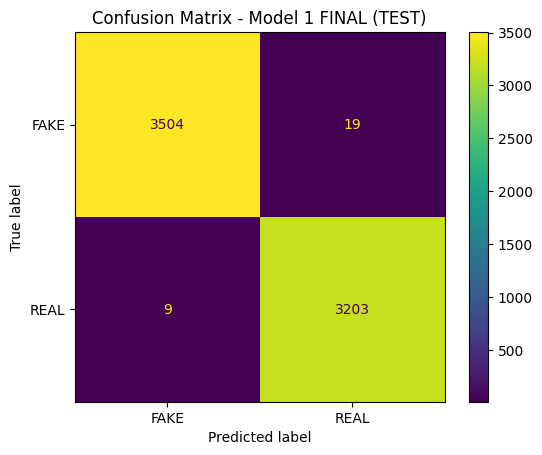

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

log_reg_final_m1 = LogisticRegression(max_iter=1000)
log_reg_final_m1.fit(X_trainval_tfidf, y_trainval)

y_test_pred_m1 = log_reg_final_m1.predict(X_test_tfidf)

macro_f1_test_m1 = f1_score(y_test, y_test_pred_m1, average="macro")
print("Macro-F1 (Model 1 FINAL - TEST):", macro_f1_test_m1)

print("\nClassification report (Model 1 FINAL - TEST):")
print(classification_report(y_test, y_test_pred_m1))

cm_test_m1 = confusion_matrix(y_test, y_test_pred_m1, labels=["FAKE", "REAL"])
disp_test_m1 = ConfusionMatrixDisplay(confusion_matrix=cm_test_m1, display_labels=["FAKE", "REAL"])
disp_test_m1.plot()
plt.title("Confusion Matrix - Model 1 FINAL (TEST)")
plt.show()


## 🏁 Concluzie – Modelul 1

Modelul clasic bazat pe TF-IDF și Logistic Regression a obținut performanțe foarte ridicate în detectarea știrilor false, atât pe setul de validare, cât și pe setul de test.

Configurarea personalizată a TF-IDF (vocabular limitat și utilizarea de bigrame) a condus la o ușoară îmbunătățire a performanței față de baseline, menținând în același timp un model mai compact și mai controlabil.

Aceste rezultate sugerează că, pentru datasetul utilizat, diferențele lexicale dintre știrile reale și cele false sunt suficient de puternice pentru a fi captate eficient prin metode NLP clasice.
